# Exercise: Complete Modeling Workflow (With Answers)

**Download: ``http://shorturl.at/crOS2/Lecture_12``**

File obsdata.csv contains four columns, each with 20 points. The columns are: time, A, B, C. 
1. Evaluate each of the following models using cross validation to find which provides the best fit.

    Model 1:

        A -> B

        B -> C


    Model 2:

         A -> B

         A -> C

    Model 3:

         A + B -> C

    All kinetics are mass action. A is starts at 5M, and all other concentrations are 0.
    Kinetics constants are in [0, 10]
    
    a. Write the full Antimony models for each of the above.
    
    b. What simulation time should you use? How many points?
    
    c. Do cross validation on each. Which has the largest $R^2$ across folds?
    
    d. Did some folds in cross validation produce much better fits than others? Why?

2. Construct a 95% confidence interval for the model with the best fit.

3. The "observational data" were generated by a model that contains a chemical species D that is not present in the other models. How might we detect that there is a missing chemical species?

Hint: You can read data in a CSV file into a numpy array using ``np.genfromtxt("obsdata.csv", delimiter=",", skip_header=True)``.

In [1]:
%matplotlib inline
import numpy as np
import model_fitting as mf

In [2]:
# Globals
num_points = 10
sim_time = 30

## Full model

In [3]:
# Model used in this example
model0 = """
     # True model
     A  -> B; k1*A
     A + B -> D; k2*A*B
     D -> C; k3*D
      
     A = 5;
     B = 0;
     C = 0;
     D = 0;
     k1 = 0.5
     k2 = 0.2
     k3 = 0.1
"""
unfitted_parameters = mf.makeParameters(constants=['k1', 'k2', 'k3'])
unfitted_parameters

name,value,initial value,min,max,vary
k1,1.00000000,1,0.00000000,10.0000000,True
k2,1.00000000,1,0.00000000,10.0000000,True
k3,1.00000000,1,0.00000000,10.0000000,True


In [4]:
noise_std = 0.2
full_obs_data = mf.makeObservations(model=model0, noise_std=noise_std, num_points=num_points, sim_time=sim_time)
obs_data = full_obs_data[:, [0, 1, 2,  4]]
obs_data

 [[       0,   4.68795, 0.237412, 0.119838],
  [ 3.33333,  0.264339,   1.9419, 0.312391],
  [ 6.66667, 0.0502646,  1.40318, 0.876776],
  [      10,         0,  1.82646,  1.14471],
  [ 13.3333,  0.209876,  1.82114,  1.04206],
  [ 16.6667,  0.258966,  1.83579, 0.814785],
  [      20,         0,  1.70902,  1.28241],
  [ 23.3333,  0.336649,  1.81928,   1.2652],
  [ 26.6667,  0.628893,  1.72459,  1.25902],
  [      30,         0,  1.82241,  1.16935]]

In [5]:
def writeCSV(data, filename="obsdata.csv"):
    import pandas as pd
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
writeCSV(obs_data)

In [6]:
obs_data = np.genfromtxt("obsdata.csv", delimiter=",", skip_header=True)
obs_data

array([[ 0.        ,  4.68795281,  0.23741222,  0.11983824],
       [ 3.33333333,  0.26433916,  1.9419014 ,  0.31239116],
       [ 6.66666667,  0.05026461,  1.40318152,  0.87677624],
       [10.        ,  0.        ,  1.82645642,  1.14471334],
       [13.33333333,  0.20987588,  1.82113539,  1.04206427],
       [16.66666667,  0.2589656 ,  1.83579222,  0.81478526],
       [20.        ,  0.        ,  1.70901976,  1.28241183],
       [23.33333333,  0.3366495 ,  1.81927732,  1.26519539],
       [26.66666667,  0.62889332,  1.72458779,  1.25902494],
       [30.        ,  0.        ,  1.82240564,  1.16935362]])

In [7]:
full_obs_data

       time,       [A],      [B],      [D],      [C]
 [[       0,   4.68795, 0.237412,        0, 0.119838],
  [ 3.33333,  0.264339,   1.9419,  1.05821, 0.312391],
  [ 6.66667, 0.0502646,  1.40318,  1.04752, 0.876776],
  [      10,         0,  1.82646, 0.543553,  1.14471],
  [ 13.3333,  0.209876,  1.82114, 0.893429,  1.04206],
  [ 16.6667,  0.258966,  1.83579, 0.656556, 0.814785],
  [      20,         0,  1.70902, 0.329493,  1.28241],
  [ 23.3333,  0.336649,  1.81928, 0.304765,   1.2652],
  [ 26.6667,  0.628893,  1.72459,  0.40211,  1.25902],
  [      30,         0,  1.82241, 0.257764,  1.16935]]

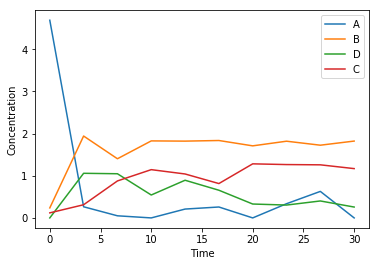

In [8]:
mf.plotTimeSeries(full_obs_data, columns=['A', 'B', 'D', 'C'])

## Candidate models

In [9]:
models = []
parameters_list = []
# Model used in this example
model = """
    # Model 1
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0
"""
parameters_list.append(mf.makeParameters(constants=['k1', 'k2']))
models.append(model)

model = """
     # Model 2
     A -> B; k1*A
     A -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0
"""
parameters_list.append(mf.makeParameters(constants=['k1', 'k2']))
models.append(model)


model = """
     # Model 3
     A + B -> C; k1*A
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
"""
parameters_list.append(mf.makeParameters(constants=['k1']))
models.append(model)

In [10]:
for model in models:
    print(model)


    # Model 1
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0


     # Model 2
     A -> B; k1*A
     A -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0


     # Model 3
     A + B -> C; k1*A
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0



## Model Analysis

In [11]:
# Evaluation using cross validation
for model, parameters in zip(models, parameters_list):
    print("\nModel: %s" % model)
    _, rsqs = mf.crossValidate(obs_data, model=model, parameters=parameters, 
                                         num_points=num_points, 
                                         method='leastsq',
                                         sim_time=sim_time,
                                         num_folds=3)
    print(rsqs)


Model: 
    # Model 1
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0

[0.7020348785505992, -0.8446379085609919, -1.1023086376047577]

Model: 
     # Model 2
     A -> B; k1*A
     A -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0

[0.682393190503739, -15.476920339798443, -1.8878841886333029]

Model: 
     # Model 3
     A + B -> C; k1*A
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0

[-2.6443817338354343, -25.20595657781094, -19.674242756378177]


In [12]:
list_parameters, rsqs = mf.crossValidate(full_obs_data, model=model0, parameters=unfitted_parameters, 
                                         num_points=num_points, method='leastsq',
                                         sim_time=sim_time,
                                         num_folds=3)
rsqs

[0.9764013163666285, 0.9394864178814735, 0.7511425169584142]

In [13]:
mf.doBootstrap(full_obs_data, model=model0, parameters=unfitted_parameters, 
                                         num_points=num_points, method='leastsq',
                                         sim_time=sim_time, count=5)

{'k1': array([2.52565996, 8.77674994]),
 'k2': array([1.03798153, 3.65512018]),
 'k3': array([0.07065004, 0.1112638 ])}

In [14]:
mf.doBootstrap(obs_data, model=models[0], parameters=parameters_list[0], 
                                         num_points=num_points,
                                         sim_time=sim_time, count=5)

{'k1': array([0.18934955, 0.2194533 ]), 'k2': array([0.0383431 , 0.04208173])}